In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from collections import defaultdict, OrderedDict

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# Setting

# Graph Designs
#sns.set(style='whitegrid', palette='muted', font_scale=1.2)
#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
#plt.rcParams['figure.figsize'] = 12, 8
#
## Ser random seed
#RANDOM_SEED = 51
#np.random.seed(RANDOM_SEED)
#torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(torch.backends.cudnn.enabled)
!python -m torch.utils.collect_env

True
<frozen runpy>:128: RuntimeWarning: 'torch.utils.collect_env' found in sys.modules after import of package 'torch.utils', but prior to execution of 'torch.utils.collect_env'; this may result in unpredictable behaviour
/media/arizenelm/a72f52e2-dbf5-4f98-aec4-590ed54c7b51/arizenelm.old/IR/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
PyTorch version: 2.3.0+cu118
Is debug build: False
CUDA used to build PyTorch: 11.8
ROCM used to build PyTorch: N/A

OS: Debian GNU/Linux 12 (bookworm) (x86_64)
GCC version: (Debian 12.2.0-14) 12.2.0
Clang version: 15.0.6
CMake version: version 3.25.1
Libc version: glibc-2.36

Python version: 3.11.2 (main, Mar  2 202

## Загрузка и анализ данных

In [5]:
train_orig = pd.read_csv('data/QuADS/QuADS - Train.csv')
validate_orig = pd.read_csv('data/QuADS/QuADS - Validate.csv')
test_orig = pd.read_csv('data/QuADS/QuADS - Test.csv')

In [6]:
train_orig.head()

,intent,sub intent,data,slots
0,agricultural_machinery,planters,what is planter used for,O O B-machinery_type B-machinery_agricultural_...
1,agricultural_machinery,rotator,what is the cost of a rotator,O O O B-machinery_price O O B-machinery_type
2,agricultural_machinery,tractors,how is a tractor used,O O O B-machinery_type B-machinery_agricultura...
3,agricultural_machinery,chisel_plow,what is the cost of chisel plow,O O O B-machinery_price O O O
4,agricultural_machinery,liquid_manure,how much does liquid manure cost,O O O O O B-machinery_price


In [7]:
validate_orig.head()

,intent,sub intent,data,slots
0,agricultural_machinery,rotator,which brand is the best for rotator,O B-machinery_general_info O O B-machinery_gen...
1,agricultural_machinery,rotator,what are the features of rotator,O O O B-machinery_general_info O B-machinery_type
2,agricultural_machinery,combine,what is a combine,O O O O
3,agricultural_machinery,produce_sorter,how much does a produce sorter cost,O O O O O O B-machinery_price
4,agricultural_machinery,subsoiler,is subsoiler very expensive,O B-machinery_type O B-machinery_price


In [8]:
test_orig.head()

,intent,sub intent,data,slots
0,agricultural_machinery,cultivator,is cultivator used for harvesting crops,O B-machinery_type B-machinery_agricultural_pr...
1,agricultural_machinery,plough,is plough used during harvesting or seeding,O B-machinery_type B-machinery_agricultural_pr...
2,agricultural_machinery,harrow,for how many years is harrow usable,O O O B-machinery_shelf_life O B-machinery_type O
3,agricultural_machinery,tractors,how is it known that a tractor is in good cond...,O O O O O O B-machinery_type O O B-machinery_g...
4,agricultural_machinery,seed_drill,how does seed drill work,O O B-machinery_agricultural_process O B-machi...


In [9]:
print(len(train_orig), len(test_orig), len(validate_orig))

1800 360 240


In [10]:
print(train_orig['intent'].unique())
print(test_orig['intent'].unique())
print()
print(train_orig['sub intent'].unique())
print(test_orig['sub intent'].unique())
print("\n", 
      all([i in set(test_orig['sub intent']) for i in set(train_orig['sub intent'])]))
print()
train_slots = set(' '.join(train_orig['slots']).split())
test_slots = set(' '.join(test_orig['slots']).split())
print(all([i in test_slots for i in train_slots]))
print(len(train_slots))

['agricultural_machinery' 'agricultural_processes' 'agrochemicals'
 'alternative_farming_methods' 'animal_husbandry' 'crop_information']
['agricultural_machinery' 'agricultural_processes' 'agrochemicals'
 'alternative_farming_methods' 'animal_husbandry' 'crop_information']

['planters' 'rotator' 'tractors' 'chisel_plow' 'liquid_manure' 'harrow'
 'roller' 'subsoiler' 'seed_drill' 'produce_sorter' 'general' 'cultivator'
 'manure_spreader' 'plough' 'sprayers' 'combine' 'irrigation' 'storage'
 'soil_preparation' 'sowing' 'harvest' 'manure' 'pesticides' 'herbicides'
 'fertilizers' 'insecticides' 'fungicides' 'horticulture'
 'organic farming' 'viticulture' 'floriculture' 'fish_farming'
 'dairy_farming' 'bee_keeping' 'sheep_farming' 'alligator_farming'
 'poultry_farming' 'pig_farming' 'sericulture' 'vegetables' 'oil_seeds'
 'fruits' 'pulses' 'dry_fruits' 'grains' 'spices']
['cultivator' 'plough' 'harrow' 'tractors' 'seed_drill' 'general'
 'produce_sorter' 'sprayers' 'manure_spreader' 'roller'

In [11]:
print(len(train_orig), len(validate_orig), len(test_orig))

1800 240 360


In [59]:
slots_ids = {i : j for i, j in enumerate(train_slots)}
intent_ids = {i : j for i, j in enumerate(train_orig['intent'].unique())}
subintent_ids = {i : j for i, j in enumerate(train_orig['sub intent'].unique())}

In [60]:
slots_vocab = {j : i for i, j in slots_ids.items()}
intent_vocab = {j : i for i, j in intent_ids.items()}
subintent_vocab = {j : i for i, j in subintent_ids.items()}

In [61]:
df = pd.concat([train_orig, test_orig, validate_orig])
df.rename(columns={'slots' : 'slot_label', 'sub intent' : 'sub_intent'}, inplace=True)
df['slot_id'] = [[slots_vocab[w] for w in x.split()] for x in df['slot_label']]
df['intent_id'] = [intent_vocab[x] for x in df['intent']]
df['subintent_id'] = [subintent_vocab[x]  for x in df['sub_intent']]

In [62]:
df.head()

,intent,sub_intent,data,slot_label,slot_id,intent_id,subintent_id
0,agricultural_machinery,planters,what is planter used for,O O B-machinery_type B-machinery_agricultural_...,"[47, 47, 54, 16, 47]",0,0
1,agricultural_machinery,rotator,what is the cost of a rotator,O O O B-machinery_price O O B-machinery_type,"[47, 47, 47, 12, 47, 47, 54]",0,1
2,agricultural_machinery,tractors,how is a tractor used,O O O B-machinery_type B-machinery_agricultura...,"[47, 47, 47, 54, 16]",0,2
3,agricultural_machinery,chisel_plow,what is the cost of chisel plow,O O O B-machinery_price O O O,"[47, 47, 47, 12, 47, 47, 47]",0,3
4,agricultural_machinery,liquid_manure,how much does liquid manure cost,O O O O O B-machinery_price,"[47, 47, 47, 47, 47, 12]",0,4


<Axes: xlabel='slot_id', ylabel='Count'>

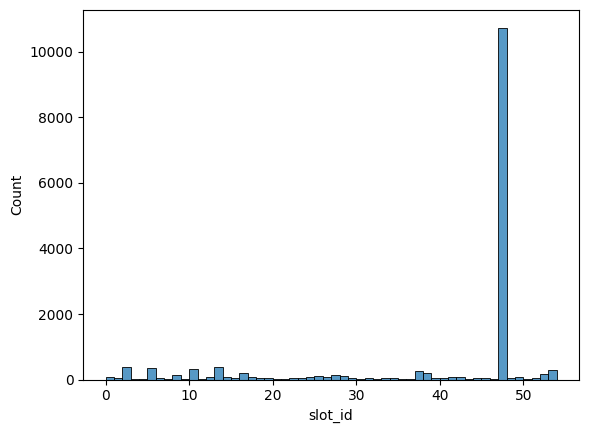

In [63]:
sns.histplot(df.explode(['slot_id'])['slot_id'], binwidth=1)

In [101]:
cnt = df.explode(['slot_id'])['slot_id'].value_counts()
O_TOKEN = cnt.index[cnt.argmax()]
print(O_TOKEN)
print(cnt[O_TOKEN])

47
10740


<Axes: xlabel='slot_id', ylabel='Count'>

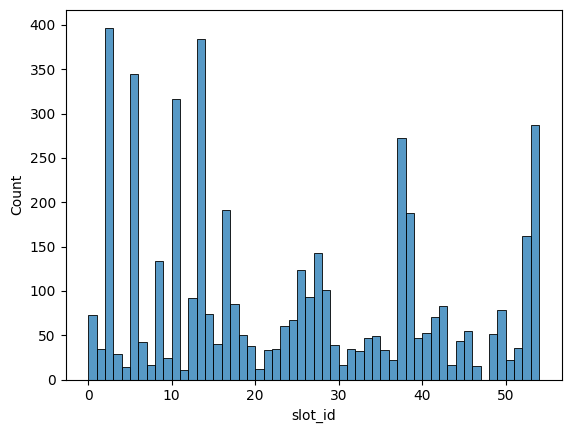

In [102]:
sns.histplot(df.explode(['slot_id']).query('slot_id != ' + str(O_TOKEN))['slot_id'], binwidth=1)

In [103]:
group_df = df.explode(['slot_id']).copy()
group_df = group_df.astype('object')
counts = group_df['slot_id'].value_counts(normalize=True)
for i in range(len(slots_ids)):
    if counts[i] < 0.01:
        group_df.loc[group_df['slot_id']==i, 'slot_id'] = 'Другие'

<Axes: ylabel='Пропорции'>

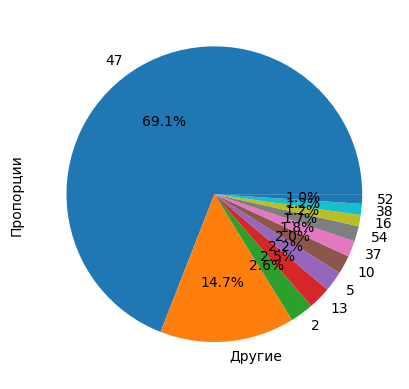

In [104]:
group_df['slot_id'].value_counts(normalize=True).plot(kind='pie', 
                                                       autopct='%1.1f%%', 
                                                       xlabel='id слота', 
                                                       ylabel='Пропорции')

In [105]:
train_df = train_orig.copy()
train_df.rename(columns={'slots' : 'slot_label', 'sub intent' : 'sub_intent'}, 
                inplace=True)
train_df['slot_id'] = [[slots_vocab[w] for w in x.split()] for x in train_df['slot_label']]
train_df['intent_id'] = [intent_vocab[x] for x in train_df['intent']]
train_df['subintent_id'] = [subintent_vocab[x] for x in train_df['sub_intent']]

In [106]:
test_df = test_orig.copy()
test_df.rename(columns={'slots' : 'slot_label', 'sub intent' : 'sub_intent'}, 
               inplace=True)
test_df['slot_id'] = [[slots_vocab[w] for w in x.split()] for x in test_df['slot_label']]
test_df['intent_id'] = [intent_vocab[x] for x in test_df['intent']]
test_df['subintent_id'] = [subintent_vocab[x] for x in test_df['sub_intent']]

In [107]:
val_df = validate_orig.copy()
val_df.rename(columns={'slots' : 'slot_label', 'sub intent' : 'sub_intent'}, 
              inplace=True)
val_df['slot_id'] = [[slots_vocab[w] for w in x.split()] for x in val_df['slot_label']]
val_df['intent_id'] = [intent_vocab[x] for x in val_df['intent']]
val_df['subintent_id'] = [subintent_vocab[x] for x in val_df['sub_intent']]

In [108]:
val_df.head()

,intent,sub_intent,data,slot_label,slot_id,intent_id,subintent_id
0,agricultural_machinery,rotator,which brand is the best for rotator,O B-machinery_general_info O O B-machinery_gen...,"[47, 25, 47, 47, 25, 47, 54]",0,1
1,agricultural_machinery,rotator,what are the features of rotator,O O O B-machinery_general_info O B-machinery_type,"[47, 47, 47, 25, 47, 54]",0,1
2,agricultural_machinery,combine,what is a combine,O O O O,"[47, 47, 47, 47]",0,15
3,agricultural_machinery,produce_sorter,how much does a produce sorter cost,O O O O O O B-machinery_price,"[47, 47, 47, 47, 47, 47, 12]",0,9
4,agricultural_machinery,subsoiler,is subsoiler very expensive,O B-machinery_type O B-machinery_price,"[47, 54, 47, 12]",0,7


In [109]:
group_df = train_df.explode(['slot_id']).copy()
group_df = group_df.astype('object')
counts = group_df['slot_id'].value_counts(normalize=True)
for i in range(len(slots_ids)):
    if counts[i] < 0.01:
        group_df.loc[group_df['slot_id']==i, 'slot_id'] = 'Другие'

<Axes: ylabel='Пропорции'>

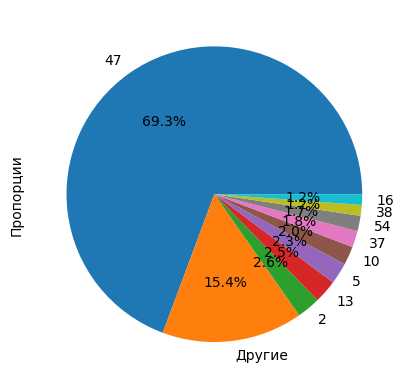

In [110]:
group_df['slot_id'].value_counts(normalize=True).plot(kind='pie', 
                                                       autopct='%1.1f%%', 
                                                       xlabel='id слота', 
                                                       ylabel='Пропорции')

## Подготовка данных для обучения модели

In [111]:
#BERT tokenizer
MODEL_NAME = 'google-bert/bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [112]:
token_lens = []

for text in df.data:
    tokens_encoded = tokenizer.encode(text, truncation=True, max_length=512)
    token_lens.append(len(tokens_encoded))

max(token_lens)

22

<Axes: ylabel='Count'>

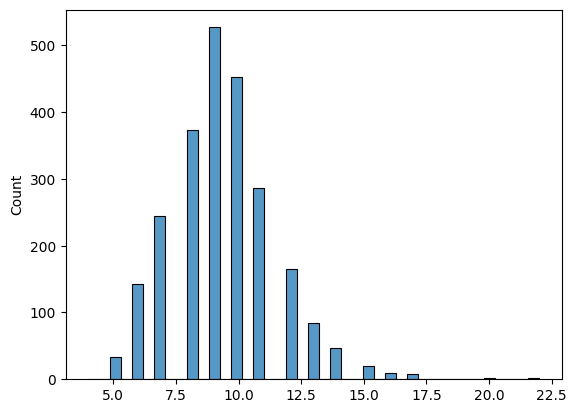

In [113]:
sns.histplot(token_lens)

In [114]:
MAX_LENGTH = 24

In [115]:
def my_tokenizer(txt) :
    return tokenizer(txt,
            add_special_tokens = True,
            max_length = MAX_LENGTH,
            return_token_type_ids = False,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True)

def pt_tokenizer(txt) :
    return tokenizer(txt,
            add_special_tokens = True,
            max_length = MAX_LENGTH,
            return_token_type_ids = False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True)


In [116]:
txt = train_df['data'][np.argmax(train_df.data.apply(lambda x: len(x)))]
print(txt)
tokens_encoded = my_tokenizer(txt)
print(tokens_encoded)
print(tokens_encoded['input_ids'])
print([tokenizer.decode(i) for i in tokens_encoded['input_ids']])

what is the best way to water a vegetable farm and how much water is required by the vegetable crop
{'input_ids': [101, 2054, 2003, 1996, 2190, 2126, 2000, 2300, 1037, 15415, 3888, 1998, 2129, 2172, 2300, 2003, 3223, 2011, 1996, 15415, 10416, 102, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]}
[101, 2054, 2003, 1996, 2190, 2126, 2000, 2300, 1037, 15415, 3888, 1998, 2129, 2172, 2300, 2003, 3223, 2011, 1996, 15415, 10416, 102, 0, 0]
['[ C L S ]', 'w h a t', 'i s', 't h e', 'b e s t', 'w a y', 't o', 'w a t e r', 'a', 'v e g e t a b l e', 'f a r m', 'a n d', 'h o w', 'm u c h', 'w a t e r', 'i s', 'r e q u i r e d', 'b y', 't h e', 'v e g e t a b l e', 'c r o p', '[ S E P ]', '[ P A D ]', '[ P A D ]']


In [117]:
print(tokenizer.tokenize(txt))

['what', 'is', 'the', 'best', 'way', 'to', 'water', 'a', 'vegetable', 'farm', 'and', 'how', 'much', 'water', 'is', 'required', 'by', 'the', 'vegetable', 'crop']


### Создаем датасет

In [118]:
class ATISDataset(Dataset):
    def __init__(self, queries, intent_id, subintent_id, slot_id, tokenizer, 
            max_len):
        self.queries = queries
        self.intent_id = intent_id
        self.subintent_id = subintent_id
        self.slot_id = slot_id
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.queries)
    def __getitem__(self, item):
        query = str(self.queries[item])
        intent_id = self.intent_id[item]
        subintent_id = self.subintent_id[item]
        slot_id = self.slot_id[item]
        
        # Tokenized and attention mask to be return
        token = tokenizer.encode_plus(
            query,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        slots = []
        count = 0
        for i in token['input_ids'].flatten().tolist():
            if i in [101, 102, 0] or tokenizer.decode(i)[0] == '#':
                slots.append(O_TOKEN)
            else:
                slots.append(slot_id[count])
                if count<len(slot_id)-1:
                    count+=1
            
        return {
            'query': query,
            'input_ids': token['input_ids'].flatten(),
            'attention_mask': token['attention_mask'].flatten(),
            'intents': torch.tensor(intent_id, dtype=torch.long),
            'subintents' : torch.tensor(subintent_id, dtype=torch.long),
            'slots': torch.tensor(slots).flatten()
        }
        

In [119]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ATISDataset(
        queries=df['data'].to_numpy(),
        intent_id=df['intent_id'].to_numpy(),
        subintent_id=df['subintent_id'].to_numpy(),
        slot_id=df['slot_id'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

In [120]:
BATCH_SIZE = 4
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LENGTH, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LENGTH, BATCH_SIZE)

In [121]:
data = next(iter(train_data_loader))
print(data.keys())
print(data['query'])
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['intents'].shape)
print(data['intents'])
print('slots: ', data['slots'])
print(data['input_ids'])

dict_keys(['query', 'input_ids', 'attention_mask', 'intents', 'subintents', 'slots'])
['what is planter used for', 'what is the cost of a rotator', 'how is a tractor used', 'what is the cost of chisel plow']
torch.Size([4, 24])
torch.Size([4, 24])
torch.Size([4])
tensor([0, 0, 0, 0])
slots:  tensor([[47, 47, 47, 54, 47, 16, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
         47, 47, 47, 47, 47, 47],
        [47, 47, 47, 47, 12, 47, 47, 54, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
         47, 47, 47, 47, 47, 47],
        [47, 47, 47, 47, 54, 16, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
         47, 47, 47, 47, 47, 47],
        [47, 47, 47, 47, 12, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
         47, 47, 47, 47, 47, 47]])
tensor([[  101,  2054,  2003,  3269,  2121,  2109,  2005,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  2054,  2003,  1996,  3465,  1997,

In [122]:

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.):
        super(Classifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        return self.linear(x)

In [123]:
# Joint model
class JointBertModel(nn.Module):
    def __init__(self, nintents, nsubintents, nslots):
        super(JointBertModel, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.intent_classifier = Classifier(input_dim=self.bert.config.hidden_size, 
                                                  num_classes=nintents, 
                                                  dropout_rate=0.05)
        self.slot_classifier = Classifier(input_dim=self.bert.config.hidden_size, 
                                              num_classes=nslots, 
                                              dropout_rate=0.05)
        self.subintent_classifier = Classifier(input_dim=self.bert.config.hidden_size, 
                                              num_classes=nsubintents, 
                                              dropout_rate=0.05)
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = output[0]
        pooled_output = output[1]
        
        intent_logits = self.intent_classifier(pooled_output)
        subintent_logits = self.subintent_classifier(pooled_output)
        slot_logits = self.slot_classifier(sequence_output)
        
        return {
            'intent': intent_logits,
            'subintent' : subintent_logits,
            'slot': slot_logits
        }
        

In [124]:
model = JointBertModel(len(intent_ids), len(subintent_ids), len(slots_ids))

In [125]:
# Testing the model
input_ids = data['input_ids']
attention_mask = data['attention_mask']
intents = data['intents']
subintents = data['subintents']
slots = data['slots']
output = model(input_ids, attention_mask)
intent_logits = output['intent']
slot_logits = output['slot']
subintent_logits = output['subintent']
intent_loss_fct = nn.CrossEntropyLoss()
slot_loss_fct = nn.CrossEntropyLoss()
subintent_loss_fct = nn.CrossEntropyLoss()
intent_loss = intent_loss_fct(intent_logits.view(-1, len(intent_ids)), intents.view(-1))
subintent_loss = subintent_loss_fct(subintent_logits.view(-1, len(subintent_ids)), subintents)
slot_loss = slot_loss_fct(slot_logits.view(-1,len(slots_ids)), slots.view(-1))
total_loss = slot_loss+intent_loss
total_loss
#intent_logits.view(-1, 26), targets.view(-1),intent_loss

tensor(6.1420, grad_fn=<AddBackward0>)

In [126]:
print(output['slot'].view(-1, len(slots_ids)).shape)
output['slot'].shape

torch.Size([96, 55])


torch.Size([4, 24, 55])

In [127]:
# Number of iterations 
EPOCHS = 12

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [128]:

# Function for a single training iteration
model.to(device)
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_intent = 0
    correct_subintent = 0
    correct_slot = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        intents = d["intents"].to(device)
        subintents = d["subintents"].to(device)
        slots = d["slots"].to(device)
        
        output = model(input_ids, attention_mask)
        intent_logits = output['intent']
        subintent_logits = output['subintent']
        slot_logits = output['slot']
        
        intent_loss = loss_fn(intent_logits.view(-1, len(intent_ids)), intents.view(-1))
        subintent_loss = loss_fn(subintent_logits.view(-1, len(subintent_ids)), subintents.view(-1))
        slot_loss = loss_fn(slot_logits.view(-1,len(slots_ids)), slots.view(-1))
        loss = slot_loss+intent_loss+subintent_loss
        
        _, intent = torch.max(intent_logits, dim=1)
        correct_intent += torch.sum(intent == intents)
        _, subintent = torch.max(subintent_logits, dim=1)
        correct_subintent += torch.sum(subintent == subintents)
        _, slot = torch.max(slot_logits.view(-1, len(slots_ids)), dim=1)
        correct_slot += torch.sum(slot == slots.view(-1))
        
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_intent.double()/n_examples, correct_subintent.double()/n_examples, \
        correct_slot.double()/n_examples/MAX_LENGTH, np.mean(losses)

In [129]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_intent = 0
    correct_slot = 0
    correct_subintent = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            intents = d["intents"].to(device)
            subintents = d["subintents"].to(device)
            slots = d["slots"].to(device)
        
            output = model(input_ids, attention_mask)
            intent_logits = output['intent']
            subintent_logits = output['subintent']
            slot_logits = output['slot']
        
            intent_loss = loss_fn(intent_logits.view(-1, len(intent_ids)), intents.view(-1))
            subintent_loss = loss_fn(subintent_logits.view(-1, len(subintent_ids)), subintents.view(-1))
            slot_loss = loss_fn(slot_logits.view(-1,len(slots_ids)), slots.view(-1))
            loss = slot_loss+intent_loss+subintent_loss
        
            _, intent = torch.max(intent_logits, dim=1)
            correct_intent += torch.sum(intent == intents)
            _, subintent = torch.max(subintent_logits, dim=1)
            correct_subintent += torch.sum(subintent == subintents)
            _, slot = torch.max(slot_logits.view(-1, len(slots_ids)), dim=1)
            correct_slot += torch.sum(slot == slots.view(-1))
        
            losses.append(loss.item())
            
            
    return correct_intent.double()/n_examples, correct_subintent.double()/n_examples, \
          correct_slot.double()/n_examples/MAX_LENGTH, np.mean(losses)

In [130]:
%%time

history = defaultdict(list)
best_accuracy = 0

torch.cuda.empty_cache() 
for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    intent_acc, subintent_acc, slot_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_df)
    )
    
    print(f"Train loss {train_loss}, intent accuracy {intent_acc},"  + \
     f"subintent accuracy {subintent_acc}, slot accuracy {slot_acc}")
    
    # Get model performance (accuracy and loss)
    val_intent_acc, val_subintent_acc, val_slot_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(val_df)
    )
    
    print(f"Val loss {val_loss}, intent accuracy {val_intent_acc}," + \
        f"subintent accuracy {val_subintent_acc}, slot accuracy {val_slot_acc}")
    print()
    
    history['train_acc'].append(intent_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_intent_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_intent_acc > best_accuracy:
        torch.save(model.state_dict(), 'working/quads/best.pt')
        best_accuracy = val_intent_acc
        
torch.save(model.state_dict(), 'working/quads/last.pt')

Epoch 1/12
----------


KeyboardInterrupt: 

In [ ]:
train_acc = [float(i.cpu()) for i in history['train_acc']]
val_acc = [float(i.cpu()) for i in history['val_acc']]
train_loss = [float(i) for i in history['train_loss']]
val_loss = [float(i) for i in history['val_loss']]

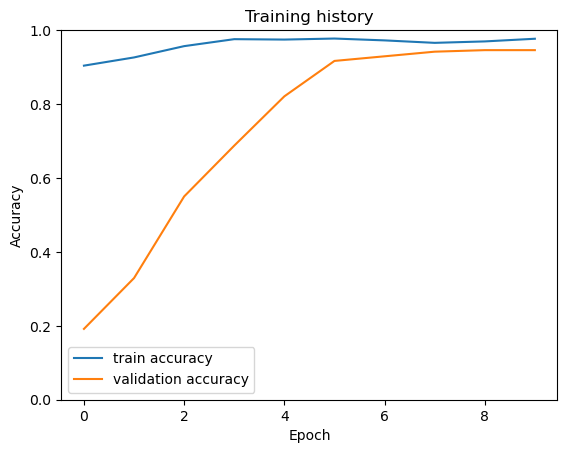

In [ ]:
# Plot training and validation accuracy
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

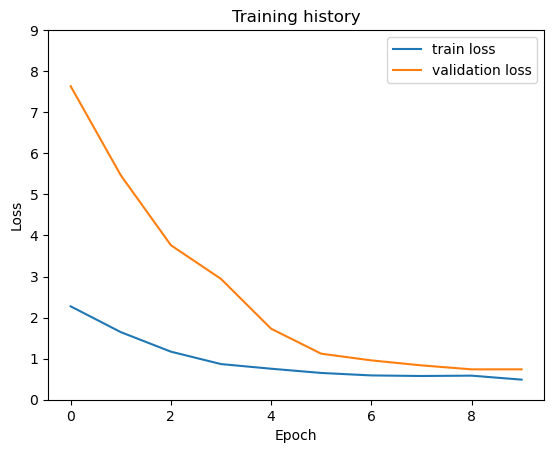

In [ ]:
# Plot training and validation loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')

# Graph chars
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 9]);

## Тестируем модель

In [ ]:
model.load_state_dict(torch.load('working/quads/best.pt'))

<All keys matched successfully>

In [ ]:

intent_acc, subintent_acc, slot_acc, _ = eval_model(
  model.to(device),
  test_data_loader,
  loss_fn,
  device,
  len(test_df)
)

intent_acc.item(), slot_acc.item()

(0.9305555555555556, 0.9648148148148148)

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    queries = []
    intent_predictions = []
    intent_prediction_probs = []
    subintent_predictions = []
    subintent_predictions_probs = []
    slot_predictions = []
    slot_prediction_probs = []
    real_intent_values = []
    real_subintent_values = []
    real_slot_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["query"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            intent_targets = d["intents"].to(device)
            subintent_targets = d["subintents"].to(device)
            slot_targets = d["slots"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, intent_pred = torch.max(outputs['intent'], dim=1)
            
            _, subintent_pred = torch.max(outputs['subintent'], dim=1)

            _, slot_pred = torch.max(outputs['slot'], dim=2)

            queries.extend(texts)
            intent_predictions.extend(intent_pred)
            intent_prediction_probs.extend(outputs['intent'])
            subintent_predictions.extend(subintent_pred)
            subintent_predictions_probs.extend(output['subintent'])
            slot_predictions.extend(slot_pred)
            slot_prediction_probs.extend(outputs['slot'])
            real_intent_values.extend(intent_targets)
            real_subintent_values.extend(subintent_targets)
            real_slot_values.extend(slot_targets)

    intent_predictions = torch.stack(intent_predictions).cpu()
    intent_prediction_probs = torch.stack(intent_prediction_probs).cpu()
    slot_predictions = torch.stack(slot_predictions).cpu()
    slot_prediction_probs = torch.stack(slot_prediction_probs).cpu()
    real_intent_values = torch.stack(real_intent_values).cpu()
    real_slot_values = torch.stack(real_slot_values).cpu()

    return queries, intent_predictions, intent_prediction_probs, \
        subintent_predictions, subintent_predictions_probs, slot_predictions, \
        slot_prediction_probs, real_intent_values, real_subintent_values, real_slot_values

In [ ]:
y_review_texts, y_intent_pred, y_intent_pred_probs, y_subintent_pred, \
y_subintent_pred_probs, y_slot_pred, y_slot_pred_probs, y_intent_test, y_subintent_test, \
y_slot_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
intent_report = classification_report(y_intent_test, y_intent_pred)
print("Intent Detection Report:")
print(intent_report)

Intent Detection Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        60
           1       0.98      0.95      0.97        60
           2       0.95      0.98      0.97        60
           3       1.00      0.70      0.82        60
           4       1.00      0.97      0.98        60
           5       0.77      1.00      0.87        60

    accuracy                           0.93       360
   macro avg       0.94      0.93      0.93       360
weighted avg       0.94      0.93      0.93       360



In [ ]:
subintent_report = classification_report(y_subintent_test, y_intent_pred)
print("Sub intent Detection Report:")
print(subintent_report)

Sub intent Detection Report:
              precision    recall  f1-score   support

           0       0.05      1.00      0.09         3
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         

In [ ]:
slot_report = classification_report(y_slot_test.view(-1), y_slot_pred.view(-1), 
                                    output_dict=True)
print("Slot Filling Report:")
print(slot_report)

Slot Filling Report:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, '1': {'precision': 0.36363636363636365, 'recall': 1.0, 'f1-score': 0.5333333333333333, 'support': 4}, '2': {'precision': 1.0, 'recall': 0.14285714285714285, 'f1-score': 0.25, 'support': 7}, '3': {'precision': 0.125, 'recall': 0.2, 'f1-score': 0.15384615384615385, 'support': 10}, '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, '5': {'precision': 1.0, 'recall': 0.15789473684210525, 'f1-score': 0.2727272727272727, 'support': 19}, '6': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 17}, '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, '8': {'precision': 0.4166666666666667, 'recall': 0.8333333333333334, 'f1-score': 0.5555555555555556, 'support': 12}, '9': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 6}, '10': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, '11':

In [ ]:
df_slot_report = pd.DataFrame(slot_report)
df_slot_report.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,accuracy,macro avg,weighted avg
precision,0.0,0.363636,1.000000,0.125000,1.0,1.000000,0.894737,0.0,0.416667,1.000000,...,0.928571,0.0,1.000000,1.000000,1.000000,0.0,0.714286,0.964815,0.58594,0.965430
recall,0.0,1.000000,0.142857,0.200000,1.0,0.157895,1.000000,0.0,0.833333,0.333333,...,0.684211,0.0,0.857143,0.100000,0.272727,0.0,1.000000,0.964815,0.51494,0.964815
f1-score,0.0,0.533333,0.250000,0.153846,1.0,0.272727,0.944444,0.0,0.555556,0.500000,...,0.787879,0.0,0.923077,0.181818,0.428571,0.0,0.833333,0.964815,0.48680,0.960438
support,1.0,4.000000,7.000000,10.000000,1.0,19.000000,17.000000,9.0,12.000000,6.000000,...,19.000000,8.0,7.000000,10.000000,11.000000,2.0,5.000000,0.964815,8640.00000,8640.000000


<AxesSubplot: >

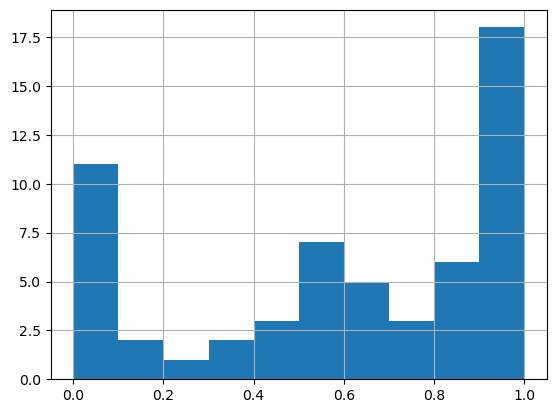

In [ ]:
df_slot_report.loc['precision'].hist()

<AxesSubplot: >

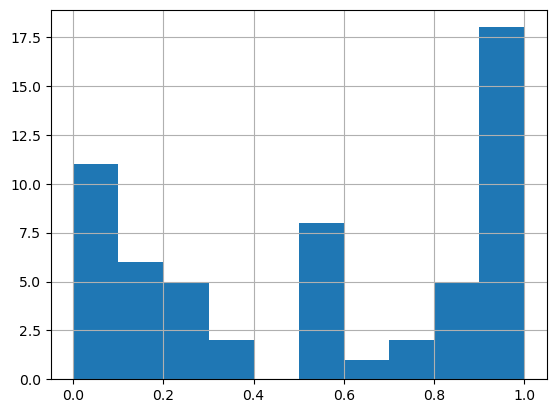

In [ ]:
df_slot_report.loc['recall'].hist()

<AxesSubplot: xlabel='support', ylabel='f1-score'>

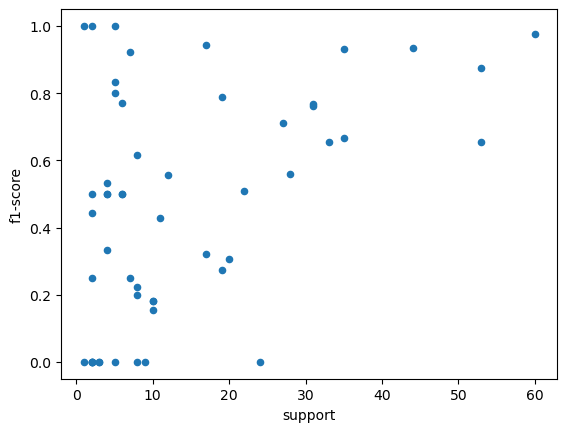

In [ ]:
df_slot_report.drop(labels=['accuracy', 'macro avg', 'weighted avg'], axis=1) \
    .T.query('support < 100').plot(x='support', y='f1-score', kind='scatter')

<AxesSubplot: xlabel='support', ylabel='recall'>

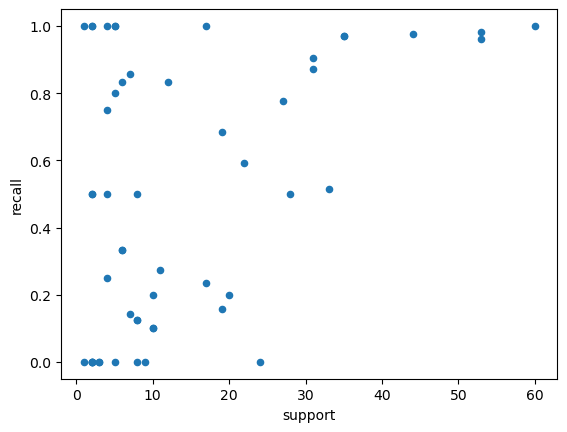

In [ ]:
df_slot_report.drop(labels=['accuracy', 'macro avg', 'weighted avg'], axis=1) \
    .T.query('support < 100').plot(x='support', y='recall', kind='scatter')

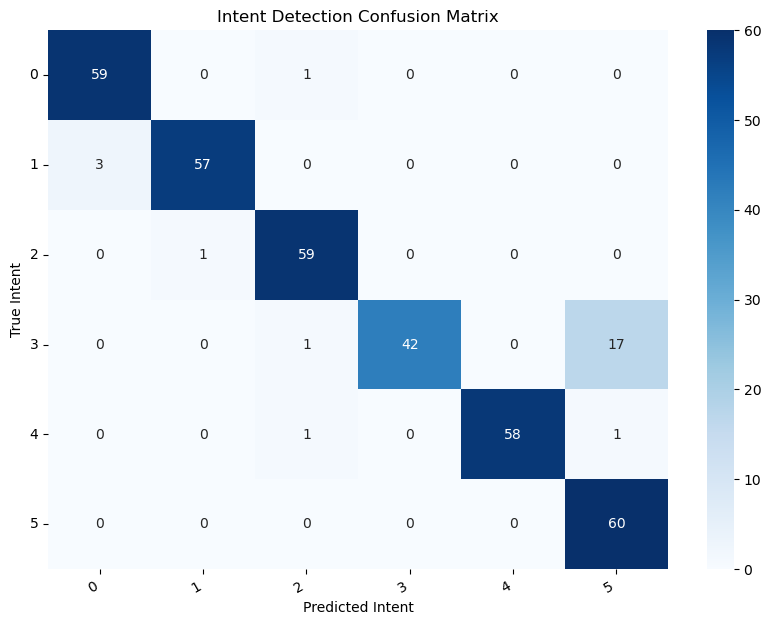

In [ ]:
it = sorted(list(intent_ids.keys()))
def show_intent_confusion_matrix(intent_confusion_matrix):
    hmap = sns.heatmap(intent_confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Intent')
    plt.xlabel('Predicted Intent')

intent_cm = confusion_matrix(y_intent_test, y_intent_pred, labels=it)
intent_df_cm = pd.DataFrame(intent_cm, index=it, columns=it)
plt.figure(figsize=(10, 7))
plt.title('Intent Detection Confusion Matrix')
show_intent_confusion_matrix(intent_df_cm)
plt.show()

In [ ]:
slots_ids

{0: 'B_agricultural_process_output',
 1: 'B-agrochemical_shelflife',
 2: 'B-crop_cost_price',
 3: 'B-machinery_price',
 4: 'B-animal_maintenance',
 5: 'B-animal_byproduct',
 6: 'B-agrochemical_price',
 7: 'B-animal_cost_price',
 8: 'B-land_cost',
 9: 'B-animal_reproduction',
 10: 'B-crop_weather',
 11: 'B-agrochemical_usecase',
 12: 'B-agrochemical_type',
 13: 'B-agrochemical_adv',
 14: 'B-crop_selling_price',
 15: 'B-method_yield',
 16: 'B-animal_weight',
 17: 'B-crop_soil_type',
 18: 'B-crop_humidity',
 19: 'B-method_requirements',
 20: 'B-method_adv',
 21: 'B-land_soil_type',
 22: 'B-machinery_general_info',
 23: 'B-animal_diseases',
 24: 'B-agricultural_process_sub_type',
 25: 'O',
 26: 'B-method_type',
 27: 'B-machinery_agricultural_process',
 28: 'B-method_duration',
 29: 'B-method-subtype',
 30: 'B-crop_growth_time',
 31: 'B-machinery_type',
 32: 'B-crop_name',
 33: 'B-method_use',
 34: 'B-method_helpline',
 35: 'B-animal_lifespan',
 36: 'B-machinery_maintenance_cost',
 37: 'B-a

In [ ]:
query = 'What is the fastest and cheapest tractor that can carry pigs'
tokens_encoded = tokenizer.encode_plus(query, return_tensors='pt')
print(tokens_encoded['input_ids'].flatten().tolist())
tokens = [tokenizer.decode(i).replace(' ', '') for i in 
          tokens_encoded['input_ids'].flatten().tolist()]
output = model(tokens_encoded['input_ids'].to(device), 
               tokens_encoded['attention_mask'].to(device))

_, intent_prediction = torch.max(output['intent'], dim=1)
_, subintent_prediction = torch.max(output['subintent'], dim=1)
_, slot_prediction = torch.max(output['slot'], dim=2)

print('Запрос:', query)
print('Токены:', tokens)
print('Намерение:', intent_ids[intent_prediction.flatten().tolist()[0]])
print('Поднамерение:', subintent_ids[subintent_prediction.flatten().tolist()[0]])
slot_labels = [slots_ids[i] for i in slot_prediction.flatten().tolist()]
print(len(slot_labels), len(tokens))
print('Слоты:')
for i in range(len(tokens)):
    print(f'{tokens[i]}:\t\t{slot_labels[i]}')

[101, 2054, 2003, 1996, 7915, 1998, 10036, 4355, 16358, 2008, 2064, 4287, 14695, 102]


Запрос: What is the fastest and cheapest tractor that can carry pigs
Токены: ['[CLS]', 'what', 'is', 'the', 'fastest', 'and', 'cheap', '##est', 'tractor', 'that', 'can', 'carry', 'pigs', '[SEP]']
Намерение: animal_husbandry
Поднамерение: pig_farming
14 14
Слоты:
[CLS]:		B-crop_humidity
what:		O
is:		O
the:		O
fastest:		O
and:		O
cheap:		B-land_cost
##est:		B-crop_humidity
tractor:		B-machinery_type
that:		O
can:		O
carry:		O
pigs:		B-animal_type
[SEP]:		B-crop_humidity
